<a href="https://colab.research.google.com/github/stchen25/COSC112_FinalProject.java/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_loc = '/content/drive/MyDrive/har/data/ag_all_labels_trunc_all_cats.pkl'

In [9]:
with open(data_loc, 'rb') as f: data = pickle.load(f)

In [6]:
len(data)

59

In [11]:
snippets = {float(i): [] for i in range(-1, 15)}

for v in data.values():
  for rec in v.values():
    for k in range(-1, 15):
      pos = np.where(rec[-1] == float(k))[0]
      if len(pos) == 0: continue
      snip_idx = np.where(np.diff(pos) > 1)[0]+1
      if len(snip_idx) == 0:
        if len(pos) == 0:
          continue
        else:
          snippet = rec[:4, pos]
          assert np.array_equal(snippet[-1].mean(), float(k))
          snippets[float(k)].append(snippet)
          continue
      start_ends = []
      start = 0
      for i in range(len(snip_idx)):
        end = snip_idx[i]
        start_ends.append((start, end))
        start = end
      start = end
      end = pos[0].size
      start_ends.append((start, end))

      for s, e in start_ends:
        timestamps = pos[s:e]
        if len(timestamps) == 0: continue
        snippet = rec[:4, timestamps]
        assert np.array_equal(snippet[-1].mean(), float(k))
        snippets[float(k)].append(snippet)

samples, cats = [], []
for k, v in snippets.items():
  for v1 in v:
    samples.append(v1)
    cats.append(k)

walking = (1, 2, 3, 4, 6, 7)
non_walking = (-1, 5, 8, 9, 10, 11, 12, 13, 14)


label_map = {-1: 'unknown',
 1: 'sidewalk',
 2: 'uneven',
 3: 'terrain',
 4: 'tilted',
 5: 'walking',
 6: 'downramp',
 7: 'upramp',
 8: 'stairsd',
 9: 'stairsu',
 10: 'eldown',
 11: 'elup',
 12: 'lying',
 13: 'sitting',
 14: 'standing'}

In [19]:
#len(samples)
samples[2]

array([[ 4.84709442e-02,  1.68169346e-02,  6.16615871e-03, ...,
        -1.03452958e-01, -1.31518528e-01, -1.03490703e-01],
       [-4.20030318e-02,  2.10160296e-02,  5.03452960e-03, ...,
         3.67603227e-02,  3.89576592e-02, -1.87165674e-03],
       [ 4.87877242e-02,  4.44356207e-04,  1.51028065e-02, ...,
         9.87800881e-02,  7.37005025e-02,  4.76376265e-02],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]], dtype=float32)

In [12]:
ws = 90  # window size
sensor = 0  # 0/1/2 for x/y/z actigraph sensors
sample_windows = []
cat_windows = []
for sample, cat in zip(samples, cats):
  sample_len = sample.shape[1]
  factor_window = int((sample_len // ws) * ws)
  sample_window = sample[sensor][:factor_window].reshape(-1, ws)
  sample_windows.extend(sample_window)
  cat_windows.extend(sample_window.shape[0] * [cat])
sample_windows = np.asarray(sample_windows)
cat_windows = np.asarray(cat_windows)

In [21]:
sample.shape



numpy.ndarray

In [10]:
sample_windows.shape

(60281, 90)

In [26]:
cat_windows.shape

(60281,)

In [30]:
len(sample_windows[0])

90

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
sample_pca = pca.fit_transform(sample_windows)


In [12]:
sample_pca.shape

(60281, 2)

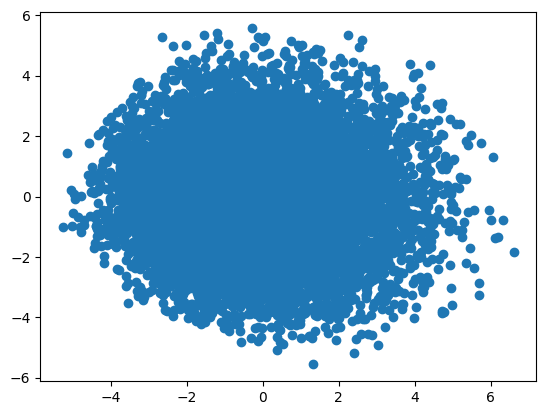

In [38]:
plt.scatter(sample_pca[:, 0], sample_pca[:,1])

In [38]:
!git clone https://github.com/DmitryUlyanov/Multicore-TSNE.git
!pip install /content/Multicore-TSNE


Cloning into 'Multicore-TSNE'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 520 (delta 5), reused 4 (delta 2), pack-reused 504
Receiving objects: 100% (520/520), 434.85 KiB | 1.42 MiB/s, done.
Resolving deltas: 100% (297/297), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./Multicore-TSNE
  Preparing metadata (setup.py) ... done
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp310-cp310-linux_x86_64.whl size=64714 sha256=1a5d3f22098d6c79977f6e1fd94ea1e7864c58eb50aff7b72b45d9c13c65b5ba
  Stored in directory: /root/.cache/pip/wheels/c1/57/25/af677306b1f065dfb04bf4a7c0d8af0846e4ea91d9371089c5
Successfully built MulticoreTSNE


In [39]:
from MulticoreTSNE import MulticoreTSNE as TSNEMC
#data_2s = np.asarray(sample_windows)

In [40]:
tsne = TSNEMC(n_components = 2, verbose = 1, n_jobs = 2)


In [41]:
reduced_data = tsne.fit_transform(np.asarray(sample_windows))

In [46]:
import pandas as pd
import plotly.express as px

In [48]:
labels = ["walking" if cat in walking else "non-walking" for cat in cat_windows]

df = pd.concat([pd.DataFrame(reduced_data), pd.DataFrame(labels)], axis=1)
df.columns = ['dim1', 'dim2', 'label']

fig = px.scatter(df, x='dim1', y='dim2', color='label')
fig.show()

In [ ]:
tsne = TSNEMC(n_components = 3, verbose = 1, n_jobs = 2)
reduced_data = tsne.fit_transform(np.asarray(sample_windows))

In [22]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=ea4314f6dd8846b0464d78a3f18ef6f19489f092c836fc33f82f0d9bf17b59ca
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=062daa3395a063f6d0c198b951a275dc9f69d2f8adf73d9706680d463b1fc93d
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [37]:
import umap
from sklearn.datasets import load_digits
import sklearn

digits = load_digits()

umap_obj = umap.UMAP(n_neighbors=50,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)

                      

In [30]:
data_2d = np.asarray(sample_windows)

In [36]:
embedded_data = umap_obj.fit_transform(data_2d)

AttributeError: ignored

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
dbscan = DBSCAN(eps = 0.3, min_samples = 5, metric = 'euclidean')

In [ ]:
clustered_data = dbscan.fit_predict(sample_pca)

In [23]:
clustered_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

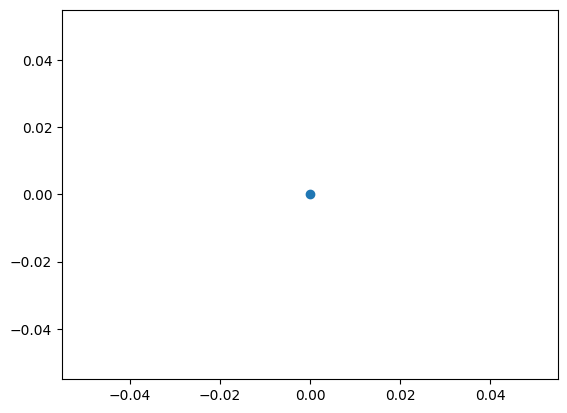

In [22]:
plt.scatter(clustered_data[0], clustered_data[0])